# **DESAFIO FINAL G2** 
# **Dataset Imagenes Covid-19 - Modelo de clasificacion supervisado en produccion.**
---

<a id="section_toc"></a> 
## Tabla de Contenidos

[Intro](#section_toc)

Armado y presentacion de dataset

$\hspace{.5cm}$[Importaciones y carga de bibliotecas](#sec_imp)

$\hspace{.5cm}$[Alcance del trabajo y caracteristicas generales](#sec_alcance)

$\hspace{.5cm}$[Analisis previos y observacion de variables](#sec_apo)

$\hspace{.9cm}$[Inspeccion de variables](#sec_apo_ds)

$\hspace{.9cm}$[Caracteristicas generales del dataset](#sec_apo_nc)

Implementacion de modelos de clasificacion supervisados

$\hspace{.5cm}$[Armado de set de entrenamiento y testing](#sec_set)
  
$\hspace{.5cm}$[KNeighborsClassifier](#sec_knn)

$\hspace{.9cm}$[Analisis](#sec_knn_a)

$\hspace{.9cm}$[Optimizacion de hiperparametros mediante GridSearchCV](#sec_knn_gs)

$\hspace{.9cm}$[Metricas y evaluacion del modelo](#sec_knn_eval)

$\hspace{.5cm}$[Gaussian Naive Bayes](#sec_gnb)

$\hspace{.9cm}$[Analisis](#sec_gnb_a)

$\hspace{.9cm}$[Metricas y evaluacion del modelo](#sec_gnb_eval)

$\hspace{.5cm}$[Logistic Regression](#sec_lr)

$\hspace{.9cm}$[Analisis](#sec_lr_a)

$\hspace{.9cm}$[Optimizacion de hiperparametros mediante GridSearchCV](#sec_lr_gs)

$\hspace{.9cm}$[Metricas y evaluacion del modelo](#sec_lr_eval)

Conclusiones

$\hspace{.5cm}$[Conclusiones](#sec_conclusiones)

---

## Armado y presentacion de dataset

<a id="sec_imp"></a> 
### Importaciones y carga de bibliotecas

[volver a TOC](#section_toc)

In [1]:
!pip install opencv-python

#### Importacion de bibliotecas generales

In [2]:
import os
import sys
import re

In [3]:
import pandas as pd
import numpy as np

In [4]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import offsetbox

import numpy as np
import skimage
import skimage.io
import skimage.transform

#### Importacion de librerias para armado y testeo de modelos

In [5]:
# operaciones sobre variables
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, make_scorer
from sklearn.pipeline import Pipeline, make_pipeline, make_union

# modelos de clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

# normalizacion de variables
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

# feature selection
from sklearn.feature_selection import SelectKBest, f_classif, f_regression


from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

#### Variables globales

In [6]:
# path relativo al repositorio de imagenes
this_path = os.path.dirname('.')
rel_dataset_path = '../../data/xrays_dataset_completo/'

# path absoluto al repositorio de imagenes
abs_dataset_path = os.path.abspath(os.path.join(this_path, rel_dataset_path))

# path absoluto a dataset de training y a dataset testing
# photos1
photos1_dataset_path = os.path.join(abs_dataset_path, "photos1")
# photos2
photos2_dataset_path = os.path.join(abs_dataset_path, "photos2")
# photos3
photos3_dataset_path = os.path.join(abs_dataset_path, "photos3")

# expresion regular para buscar solamente imagenes
pat = '(jpeg|jpg|png)$'
reg = re.compile(pat, flags = re.IGNORECASE)

<a id="sec_alcance"></a> 
### Alcance de trabajo y caracteristicas generales

[volver a TOC](#section_toc)

#### **Rx de tórax en pacientes COVID-19**
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7269964/

Las radiografías de tórax son la modalidad de imagen más utilizada para casos de Covid-19 sospechosos y confirmados.
Los hallazgos en las imágenes pueden variar según la etapa de la enfermedad (días desde los primeros síntomas) y según la gravedad de la misma. Ejemplo:

<img src="https://github.com/DHDSDesafios/DH_DS_desafio_3/raw/master/data/severidad_covid19.jpg" alt="Drawing" style="width: 600px;"/>

La sensibilidad del método varía según los hallazgos y según la técnica: en promedio 69%, y la especificidad es baja, promedio 40%.

TÉCNICA:
 * paciente en bipedestación 
 * apoya el pecho al centro de chasis con las muñecas colocadas en las caderas y los hombros hacia delante.
 *  El rayo debe dirigirse horizontalmente al centro del chasis o hacia la altura de la sexta vértebra dorsal con distancia tubo-película de 1,80 y no debe ser menor a 1,5 m.
 *  en inspiración completa.

<img src="https://github.com/DHDSDesafios/DH_DS_desafio_3/raw/master/data/radiografia_tecnica.png" alt="Drawing" style="width: 400px;"/>


##### **Hallazgos de RX de tórax en pacientes con COVID-19**
 https://pubs.rsna.org/doi/10.1148/radiol.2020201160

Lo más frecuente que podemos encontrar son infiltrados en los campos pulmonares con distintos grados (desde vidrio esmerilado hasta consolidación del parénquima pulmonar),que suelen estar en zonas periféricas del pulmón.

Ejemplo de grados:

<img src="https://github.com/DHDSDesafios/DH_DS_desafio_3/raw/master/data/foto_grados_covid19.jpg" alt="Drawing" style="width: 600px;"/>


##### **Hallazgos de RX de tórax en pacientes con COVID-19** 
 https://pubs.rsna.org/doi/10.1148/ryct.2020200280

En este último cuadro podemos ver que pacientes con COVID + pueden tener RX normales.

<img src="https://github.com/DHDSDesafios/DH_DS_desafio_3/raw/master/data/table2.jpg" alt="Drawing" style="width: 600px;"/>
<img src="https://github.com/DHDSDesafios/DH_DS_desafio_3/raw/master/data/table3.png" alt="Drawing" style="width: 600px;"/>


La tomografía de tórax tiene mayor sensibilidad y especificidad, de cualquier modo es difícil poder diferenciar. 
Excepto por una mayor prevalencia de distribución periférica, la afectación de los lóbulos superior y medio, la neumonía viral COVID-19 y no COVID presentaron hallazgos de TC de tórax superpuestos.

 * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7233414/
 * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7320914/

**COMPARACIÓN CON OTRAS NEUMONÍAS VÍRICAS**

Recientemente se ha publicado un estudio comparativo entre la neumonía por COVID y otras neumonías víricas. Las características más discriminatorias para la neumonía por COVID-19 incluyeron:
 * Distribución periférica (80% vs. 57%, p <0.001)
 * Opacidad de vidrio deslustrado (91% vs. 68%, p <0.001)
 * Engrosamiento vascular (58% frente a 22%, p <0,001).
Pese a este estudio la opinión más extendida es que la neumonía por COVID-19 y otras neumonías víricas pueden ser indistinguibles, de aquí nace la dificultad diagnóstica.



<a id="sec_apo"></a> 
### Analisis previos y observacion de variables

[volver a TOC](#section_toc)

Fuente de repositorio de imagenes:

* [Covid-19 Image Dataset](https://www.kaggle.com/pranavraikokte/covid19-image-dataset). Usability: 8.8
 * Dataset para deteccion de casos de Covid o Neumonia a traves de imagenes de radiografias de torax.
 * Las imagenes fueron liberadas por la Universidad de Montreal.


* [COVID19 High quality images](https://www.kaggle.com/theroyakash/covid19). Usability: 5.0
 * Dataset para deteccion de casos de Covid o Neumonia a traves de imagenes de radiografias de torax.
 * Fuente no oficial. Imagenes extraidas desde sitios publicos mediante Web Scrapping.

Ambos datasets se encuentran dispuestos en una estructura de directorios que comienza con la separacion de carpetas de training y testing. Luego a partir de estas carpetas se crean nuevas carpetas que identifican los casos de Covid, Neumonia y casos sin afecciones.

Para poder distribuir de forma uniforme el set de datos utilizados para testing y training, unificamos ambos repositorios en la siguiente estructura de directorios:

<code>
$ tree -d .

.
├── photos1
│   ├── Covid
│   ├── Normal
│   └── Viral Pneumonia
├── photos2
│   ├── Covid
│   ├── Normal
│   └── Viral Pneumonia
└── photos3
    ├── Covid
    ├── Normal
    └── Viral Pneumonia
</code>

Con el armado del dataset delegaremos luego en los metodos `train_test_split()` y `StratifiedKFold()` de la bilbioteca scikit-learn la distribucion del set de datos para training y testing.

<a id="sec_apo_ds"></a> 
#### Inspeccion de variables

[volver a TOC](#section_toc)

**Comprobacion de carga de ruta de imagenes desde el sistema operativo**

In [7]:
path_label = [path for path in os.listdir(photos1_dataset_path)]

In [8]:
print(path_label)

['Normal', 'Viral Pneumonia', 'Covid']


#### Inspeccion de imagenes

**Coronavirus**

A continuacion se presentan imagenes de ejemplo de pacientes con Covid-19. Las mismas se utilizaran mas adelante para entrenar los modelos de clasificacion supervisado.

In [9]:
imcor1 = cv2.imread(rel_dataset_path + '/photos1/Covid/0100.jpeg', cv2.COLOR_BGR2GRAY)
imcor2 = cv2.imread(rel_dataset_path + '/photos1/Covid/0102.jpeg', cv2.COLOR_BGR2GRAY)
imcor3 = cv2.imread(rel_dataset_path + '/photos1/Covid/0105.png', cv2.COLOR_BGR2GRAY)
imcor4 = cv2.imread(rel_dataset_path + '/photos1/Covid/0106.jpeg', cv2.COLOR_BGR2GRAY)

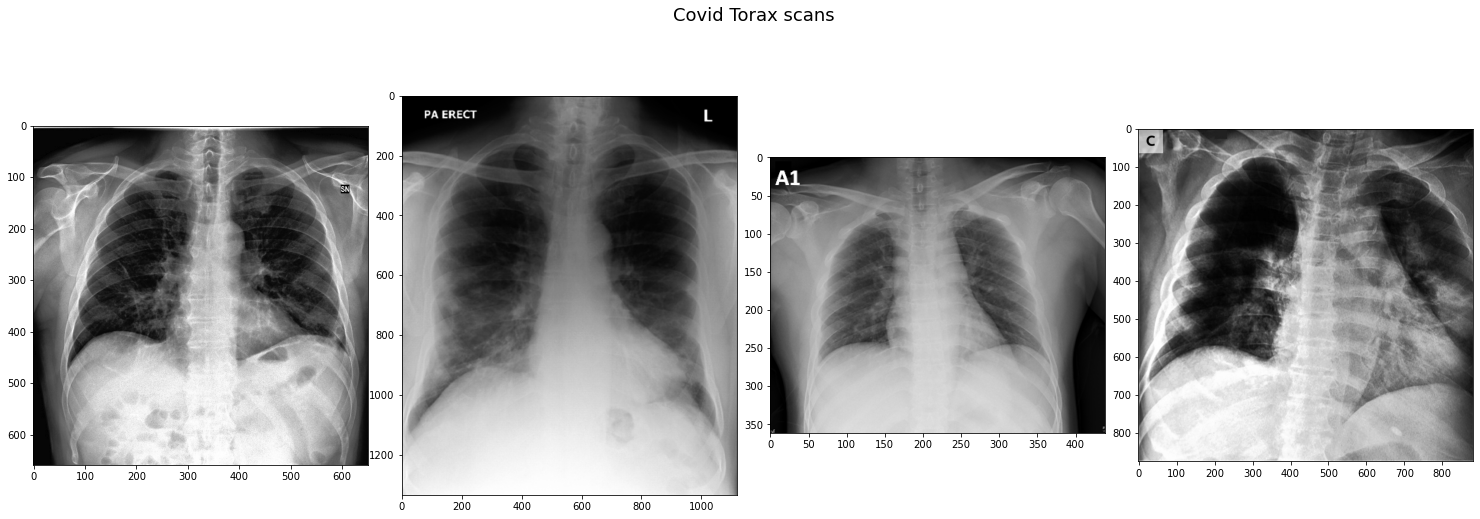

In [10]:
fig, axs = plt.subplots(1,4,figsize=(20,20))
fig.suptitle('Covid Torax scans', y=0.70, fontsize=18)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)
axs[0].imshow(imcor1)
axs[1].imshow(imcor2)
axs[2].imshow(imcor3)
axs[3].imshow(imcor4)
plt.show()

**Neumonia**

A continuacion se presentan imagenes de ejemplo de pacientes con Neumonia. Las mismas se utilizaran mas adelante para entrenar los modelos de clasificacion supervisado.

In [11]:
imneu1 = cv2.imread(rel_dataset_path + '/photos1/Viral Pneumonia/0101.jpeg', cv2.COLOR_BGR2GRAY)
imneu2 = cv2.imread(rel_dataset_path + '/photos1/Viral Pneumonia/0102.jpeg', cv2.COLOR_BGR2GRAY)
imneu3 = cv2.imread(rel_dataset_path + '/photos1/Viral Pneumonia/0103.jpeg', cv2.COLOR_BGR2GRAY)
imneu4 = cv2.imread(rel_dataset_path + '/photos1/Viral Pneumonia/0104.jpeg', cv2.COLOR_BGR2GRAY)

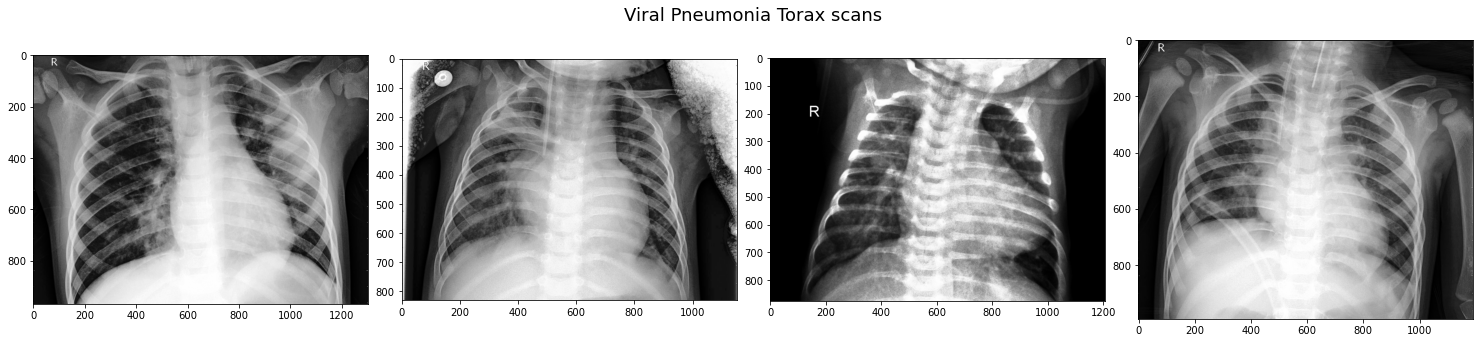

In [12]:
fig, axs = plt.subplots(1,4,figsize=(20,20))
fig.suptitle('Viral Pneumonia Torax scans', y=0.62, fontsize=18)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)
axs[0].imshow(imneu1)
axs[1].imshow(imneu2)
axs[2].imshow(imneu3)
axs[3].imshow(imneu4)
plt.show()

**Normal**

A continuacion se presentan imagenes sin ninguna afeccion pulmonar. Las mismas se utilizaran mas adelante para entrenar los modelos de clasificacion supervisado.

In [13]:
imnor1 = cv2.imread(rel_dataset_path + '/photos1/Normal/0101.jpeg', cv2.COLOR_BGR2GRAY)
imnor2 = cv2.imread(rel_dataset_path + '/photos1/Normal/0102.jpeg', cv2.COLOR_BGR2GRAY)
imnor3 = cv2.imread(rel_dataset_path + '/photos1/Normal/0103.jpeg', cv2.COLOR_BGR2GRAY)
imnor4 = cv2.imread(rel_dataset_path + '/photos1/Normal/0105.jpeg', cv2.COLOR_BGR2GRAY)

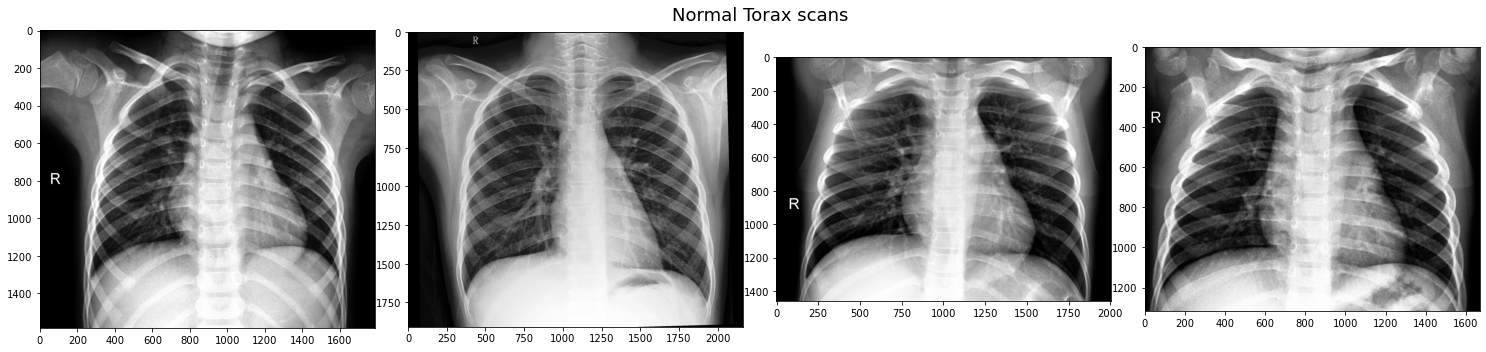

In [14]:
fig, axs = plt.subplots(1,4,figsize=(20,20))
fig.suptitle('Normal Torax scans', y=0.62, fontsize=18)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)
axs[0].imshow(imnor1)
axs[1].imshow(imnor2)
axs[2].imshow(imnor3)
axs[3].imshow(imnor4)
plt.show()

<a id="sec_apo_ds"></a> 
### Caracteristicas generales del dataset.

[volver a TOC](#section_toc)

**Parametros de tratamiento general sobre las imagenes**

Analisis segun las siguientes condiciones:
   
 * Tamaño de imagenes ajustados a 100 pixeles x 100 pixeles.
 * Uso de escala de grises.
 * Uso de [**Biblioteca OpenCV**](https://opencv.org/)
 
La biblioteca OpenCV permitio facilmente trabajar con el mapa de bits de cada pixel gracias a su integracion con Numpy. A traves de la utilizacion de metodos de OpenCV podemos generar una matriz de np.array con la distribucion de colores de cada pixel.
A traves del metodo `flatten()` de OpenCV es posible transformar la matriz np.array en un vector. 

Entonces cada vector constituira una imangen de 100 x 100 pixeles distribuida en una sola dimension.

**Imagen ejemplo**

In [15]:
imgtest = cv2.imread(rel_dataset_path + '/photos1/Covid/0100.jpeg', cv2.IMREAD_COLOR)

In [16]:
imgtest = cv2.cvtColor(imgtest, cv2.COLOR_BGR2GRAY)

In [17]:
imgtest = cv2.resize(imgtest, (100,100))

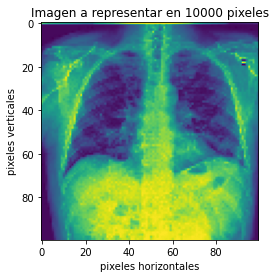

In [18]:
plt.imshow(imgtest)
plt.xlabel('pixeles horizontales')
plt.ylabel('pixeles verticales')
plt.title('Imagen a representar en 10000 pixeles')
plt.show()

In [19]:
imgtest.shape

(100, 100)

In [20]:
imgtest.flatten().shape

(10000,)

**Armado de dataset**

La funcion `new_dataset()` se desarrollo para poder transformar los distintos repositorios de imagenes en una matriz que contenga una lista de vectores correspondiente a cada imagen a analizar.

In [21]:
def new_dataset(dataset_path):
    '''
    creacion de nuevo dataset a partir de repositorio de imagenes
    dataset_path: ruta absoluta donde se encuentran las imagenes, test o train
    salida: tupla con:
        * matriz de dos dimensiones con mapa de bits de cada imagen (cada registro o lista de una dimension es una imagen) - Feature
        * lista de una dimension con valores numericos que representan la clase a la que pertenece la imagen - Target
        * lista de una dimension con las etiquetas de clase a la que pertenece cada imagen
    '''
    imgs_label = []
    imgs = []
    for pathlabel in os.listdir(dataset_path):
        label = os.path.join(dataset_path, pathlabel)
        for file in os.listdir(label):
            if re.search(pat, file) is not None:
                img = cv2.imread(os.path.join(label, file), cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (100,100))
                img = img.flatten()
                imgs.append(img)
                imgs_label.append(pathlabel)
                
    label_to_id_dict = {v:i for i,v in enumerate(np.unique(imgs_label))}
    label_ids = np.array([label_to_id_dict[x] for x in imgs_label])
    
    return np.array(imgs), label_ids, np.array(imgs_label)

### Preparacion del dataset

Unificacion de set de train y testing para aplicar una estrategia de separacion a traves de los metodos de scikit learn. Se busca mantener la proporcionalidad de la clases de la variable target.

In [22]:
photos1_X, photos1_y, photos1_labels = new_dataset(photos1_dataset_path)
photos2_X, photos2_y, photos2_labels = new_dataset(photos2_dataset_path)
photos3_X, photos3_y, photos3_labels = new_dataset(photos3_dataset_path)

**Features**

Matriz que contiene en cada vector la distribucion de colores por pixel de cada imagen.

In [23]:
photos1_X

array([[ 57,  65,  68, ...,   0,   0,   0],
       [ 20,  30,  38, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [222, 177, 180, ..., 109, 105, 100],
       [  7,   8,   8, ...,  11,  12,  30],
       [ 46,  32,  27, ...,  38,  44,  52]], dtype=uint8)

**Target**

Labels que hacen referencia a que clase pertenece cada vector.

Entonces:
 * 0 - Corresponde a los enfermos con COVID: **_Covid_**.
 * 1 - Corresponde a los pacientes saludables: **_Normal_**.
 * 2 - Corresponde a los enfermos con Neumonía: **_Viral Pneumonia_**.

In [24]:
photos1_labels

array(['Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Viral Pneumonia', 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'Covid',
       'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid',
       'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid',
       'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid', 'Covid',
       'Covid', 'Covid', 'Covid', 'Covid'], dtype='<U15')

In [25]:
photos1_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Estructura de cada set de imagenes cargado.

In [26]:
display(photos1_X.shape, photos1_y.shape, photos1_labels.shape)
display(photos2_X.shape, photos2_y.shape, photos2_labels.shape)
display(photos3_X.shape, photos3_y.shape, photos3_labels.shape)

(66, 10000)

(66,)

(66,)

(251, 10000)

(251,)

(251,)

(353, 10000)

(353,)

(353,)

**Features y target como objetos de pandas**

La estructura final del dataset de features esta conformado por:

* 670 imagenes estructuradas en vectores.
* 10000 features correspondientes a la escala de colores de cada pixel representado entre 0 a 255.

In [27]:
numpy_append = np.append(photos1_X, photos2_X, axis=0)
data_features = pd.DataFrame(np.append(numpy_append, photos3_X, axis=0))

In [28]:
data_features

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,57,65,68,64,65,69,70,63,56,52,...,123,116,61,24,8,2,0,0,0,0
1,20,30,38,85,110,116,145,116,122,115,...,121,107,80,151,129,77,12,0,0,0
2,0,0,0,139,143,196,178,172,169,168,...,48,27,2,7,13,21,21,0,0,0
3,0,0,0,42,32,34,44,46,53,182,...,135,102,175,178,163,252,255,0,0,0
4,0,0,0,0,99,109,115,119,127,174,...,34,23,2,5,8,9,9,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,16,9,6,5,4,3,9,12,12,16,...,108,101,89,72,66,57,39,5,3,16
666,7,8,8,8,7,7,7,6,6,5,...,36,28,2,2,5,8,10,11,12,30
667,46,32,27,253,225,237,238,96,41,42,...,76,56,28,30,33,36,37,38,44,52
668,1,0,0,0,0,1,1,1,1,1,...,177,169,132,63,16,2,0,0,0,1


**Target**

In [29]:
numpy_append = np.append(photos1_y, photos2_y, axis=0)
data_target = pd.Series(np.append(numpy_append, photos3_y, axis=0), name='target')

**Dataset final**

In [30]:
data_features.shape, data_target.shape

((670, 10000), (670,))

**Dataset unico**

In [31]:
target = data_target.to_frame()

In [32]:
target.sample(3)

,target
262,0
201,2
616,0


In [33]:
data = data_features.join(data_target)

In [34]:
data.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,target
616,53,38,38,38,38,38,38,35,34,32,...,105,97,84,73,3,8,14,19,21,0
245,8,8,10,21,13,2,21,8,9,22,...,17,1,1,1,1,1,1,1,1,0
329,54,64,72,116,132,136,150,136,139,136,...,131,112,153,143,109,42,2,0,0,1
30,0,0,0,1,4,10,15,17,29,30,...,3,0,0,0,0,0,0,0,0,2
144,0,0,0,0,0,1,4,6,9,11,...,56,77,11,0,0,0,0,0,0,2


---

## PCA

In [35]:
from sklearn.decomposition import PCA

In [36]:
data_features = data_features.rename(columns=lambda x: 'px_'+str(x), index=lambda y: 'img_'+str(y)) # prefijo px a columnas e img a filas

In [37]:
data_features.head(5)

,px_0,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_9990,px_9991,px_9992,px_9993,px_9994,px_9995,px_9996,px_9997,px_9998,px_9999
img_0,57,65,68,64,65,69,70,63,56,52,...,123,116,61,24,8,2,0,0,0,0
img_1,20,30,38,85,110,116,145,116,122,115,...,121,107,80,151,129,77,12,0,0,0
img_2,0,0,0,139,143,196,178,172,169,168,...,48,27,2,7,13,21,21,0,0,0
img_3,0,0,0,42,32,34,44,46,53,182,...,135,102,175,178,163,252,255,0,0,0
img_4,0,0,0,0,99,109,115,119,127,174,...,34,23,2,5,8,9,9,0,0,0


In [38]:
data_features.shape

(670, 10000)

In [39]:
data_features.mean(axis=0)

px_0       34.680597
px_1       37.907463
px_2       40.097015
px_3       45.374627
px_4       48.904478
             ...    
px_9995    44.532836
px_9996    39.932836
px_9997    35.337313
px_9998    33.294030
px_9999    32.192537
Length: 10000, dtype: float64

In [40]:
data_features.var(axis=0)

px_0       2615.990505
px_1       2693.315789
px_2       2639.104176
px_3       2955.218189
px_4       3032.203119
              ...     
px_9995    4181.436140
px_9996    3955.503703
px_9997    3571.924914
px_9998    3384.814763
px_9999    3153.928494
Length: 10000, dtype: float64

In [41]:
std = StandardScaler()

In [42]:
features_std = pd.DataFrame(std.fit_transform(data_features), index=data_features.index, columns=data_features.columns)

In [43]:
features_std.sample(5)

,px_0,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_9990,px_9991,px_9992,px_9993,px_9994,px_9995,px_9996,px_9997,px_9998,px_9999
img_41,-0.659001,-0.711697,-0.722662,-0.743255,-0.743389,-0.782718,-0.751822,-0.797668,-0.839613,-0.812737,...,1.605500,1.718264,1.859312,2.008169,2.168548,2.235789,2.308302,2.472544,2.592312,2.705151
img_640,-0.522038,-0.576714,-0.644740,-0.706437,-0.761563,-0.800355,-0.841885,-0.888583,-0.950171,-0.979493,...,0.803118,0.793421,0.838226,0.396111,0.159547,0.084610,-0.062579,-0.374028,-0.555494,-0.520200
img_518,-0.678567,-0.730980,-0.781103,-0.798482,-0.707041,-0.465261,-0.319521,-0.306724,-0.084129,-0.108654,...,-0.773493,-1.001052,-1.033765,-0.896441,-0.769990,-0.689195,-0.635409,-0.591707,-0.572695,-0.573659
img_192,-0.678567,-0.692413,-0.586299,-0.522348,-0.525304,-0.465261,-0.463621,-0.470372,-0.415805,0.002517,...,0.268196,0.199864,0.270956,-0.431703,-0.500124,-0.673719,-0.635409,-0.591707,-0.572695,-0.448921
img_244,0.260610,0.252467,0.290315,0.048330,0.074431,-0.112531,-0.157408,-0.124893,-0.194688,-0.219825,...,1.718115,1.980533,2.086221,2.255061,2.333466,2.498882,2.371949,2.573011,2.145083,1.315221


In [44]:
features_std.shape

(670, 10000)

In [45]:
features_std.mean(axis=0)

px_0      -7.158453e-17
px_1      -1.444947e-16
px_2      -6.893325e-17
px_3      -2.253587e-17
px_4      -1.372037e-16
               ...     
px_9995    7.854414e-17
px_9996   -9.213194e-17
px_9997    6.760761e-17
px_9998    2.773901e-16
px_9999    1.882408e-16
Length: 10000, dtype: float64

In [46]:
pca_pixels = PCA()
pca_pixels.fit(features_std)

PCA()

In [47]:
pca_pixels.components_.shape

(670, 10000)

In [48]:
pca_pixels.components_[0:3]

array([[ 2.71888144e-03,  1.97205009e-03,  4.72639090e-05, ...,
         1.62730090e-02,  1.53777419e-02,  1.43316082e-02],
       [-1.62648282e-03, -2.06649083e-03, -3.40555449e-03, ...,
        -6.04824756e-04, -6.26182374e-04, -8.93822501e-04],
       [ 8.11995568e-03,  7.14884033e-03,  8.35734845e-03, ...,
         3.05462775e-03,  3.37240224e-03,  4.09758923e-03]])

In [49]:
pca_loadings = pd.DataFrame(pca_pixels.components_.T, index=data_features.columns, columns=data_features.index)

In [50]:
pca_loadings.T.dot(pca_loadings)

,img_0,img_1,img_2,img_3,img_4,img_5,img_6,img_7,img_8,img_9,...,img_660,img_661,img_662,img_663,img_664,img_665,img_666,img_667,img_668,img_669
img_0,1.000000e+00,1.833386e-16,1.908196e-17,-6.459134e-16,-4.293441e-16,1.088539e-16,-1.370432e-16,7.654467e-17,-4.108042e-16,1.335737e-16,...,2.710505e-19,-1.073360e-17,-1.084202e-18,-1.572093e-18,4.702727e-18,-4.770490e-18,7.129053e-18,1.002887e-17,-8.023096e-18,2.577691e-17
img_1,1.833386e-16,1.000000e+00,2.315077e-16,3.183353e-16,8.031770e-16,8.860100e-16,-1.721713e-16,-2.455718e-16,3.504141e-16,2.476318e-16,...,4.065758e-19,1.227859e-17,1.536857e-17,-6.315478e-18,-1.496199e-17,6.844026e-18,-1.134347e-17,1.260385e-17,4.285987e-18,-4.939896e-18
img_2,1.908196e-17,2.315077e-16,1.000000e+00,7.886216e-17,-3.263449e-16,3.474868e-16,-2.059984e-18,2.648164e-16,-1.955088e-16,-4.688361e-16,...,5.675121e-19,-9.012431e-18,-1.166026e-17,9.025983e-18,6.694948e-18,-9.419006e-19,-5.641239e-18,1.330858e-17,-8.294147e-18,-1.148577e-17
img_3,-6.459134e-16,3.183353e-16,7.886216e-17,1.000000e+00,5.056719e-16,-1.621153e-16,-2.891025e-16,2.897530e-17,2.347298e-17,-7.337338e-17,...,-3.638007e-18,7.657178e-18,2.671203e-17,-2.211772e-17,-6.545871e-18,2.175181e-18,-1.935979e-17,-1.734723e-18,9.812030e-18,3.911259e-17
img_4,-4.293441e-16,8.031770e-16,-3.263449e-16,5.056719e-16,1.000000e+00,-9.367507e-17,1.517883e-17,-2.476318e-16,3.123586e-16,-2.350550e-16,...,-2.595309e-17,-1.084202e-18,-6.667843e-18,9.568084e-18,8.172174e-18,-1.029992e-17,1.162129e-17,-5.692061e-18,-2.602085e-18,1.327470e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
img_665,-4.770490e-18,6.844026e-18,-9.419006e-19,2.175181e-18,-1.029992e-17,5.963112e-18,-8.673617e-19,3.957338e-18,9.073417e-18,-1.355253e-19,...,1.915989e-17,2.339166e-17,5.475221e-17,-5.198749e-17,5.476576e-17,1.000000e+00,4.450650e-17,-5.786929e-18,8.456777e-17,-1.035413e-17
img_666,7.129053e-18,-1.134347e-17,-5.641239e-18,-1.935979e-17,1.162129e-17,4.499439e-18,-1.485526e-17,-1.569044e-17,7.616520e-18,1.542278e-17,...,-4.644451e-17,1.467739e-17,1.240598e-16,2.927346e-18,5.052382e-17,4.450650e-17,1.000000e+00,-5.488773e-18,-4.008838e-17,3.577867e-18
img_667,1.002887e-17,1.260385e-17,1.330858e-17,-1.734723e-18,-5.692061e-18,5.583641e-18,-1.843144e-18,-2.981556e-18,2.818926e-18,-3.327145e-18,...,-2.412350e-17,-4.594307e-17,-3.908549e-17,5.041540e-18,-2.358140e-17,-5.786929e-18,-5.488773e-18,1.000000e+00,-2.111484e-17,1.059130e-17
img_668,-8.023096e-18,4.285987e-18,-8.294147e-18,9.812030e-18,-2.602085e-18,-1.696776e-17,2.493665e-18,-8.185726e-18,4.282599e-18,-6.261268e-18,...,6.366977e-17,-2.854162e-17,-1.227859e-17,6.225353e-17,2.976135e-17,8.456777e-17,-4.008838e-17,-2.111484e-17,1.000000e+00,-3.457521e-16


In [51]:
pca_transform = pca_pixels.fit_transform(features_std)

In [52]:
pca_transform.shape

(670, 670)

In [53]:
df_pca = pd.DataFrame(pca_transform, index=features_std.index)
df_pca

,0,1,2,3,4,5,6,7,8,9,...,660,661,662,663,664,665,666,667,668,669
img_0,-39.360898,-12.858138,-41.974392,-41.177494,-13.314813,-35.626677,12.423074,-0.866534,10.966711,-15.602069,...,1.808180e-29,4.297238e-30,-5.929595e-31,-5.440345e-32,2.025110e-33,-8.689641e-35,-6.675877e-36,1.040183e-38,1.770615e-18,-2.919263e-17
img_1,-11.017395,-22.036466,-53.725946,-19.404354,-36.471215,-2.790731,2.270321,-16.658048,-0.014936,-18.145701,...,1.584646e-29,-4.535920e-30,4.912332e-30,1.551465e-30,5.162213e-30,-2.864619e-30,-3.186316e-30,-9.248929e-31,1.770615e-18,-2.919263e-17
img_2,-65.529407,-17.872583,-9.359827,-2.566064,25.742071,6.385779,-19.792459,21.730811,-21.855676,-1.934458,...,2.188055e-29,7.631904e-30,8.276291e-30,-1.190024e-30,-6.747851e-30,-1.359474e-30,2.448878e-31,-6.038997e-30,1.770615e-18,-2.919263e-17
img_3,-43.535992,-5.678571,-22.138414,6.361306,18.808368,36.132738,-35.520068,32.789909,-2.472438,-14.462491,...,2.149112e-29,4.675812e-30,2.159982e-30,-4.660130e-30,-4.425288e-30,3.583983e-30,5.362025e-30,7.206354e-31,1.770615e-18,-2.919263e-17
img_4,-29.749213,-20.183565,-60.277365,-24.283814,-20.397376,12.185633,-20.237241,-31.640962,-0.468250,15.706337,...,2.029454e-29,-1.161971e-29,-4.075623e-30,-4.967361e-30,1.345209e-30,-6.473636e-31,-7.284041e-30,3.493626e-30,1.770615e-18,-2.919263e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
img_665,40.584046,53.151360,-9.294606,-14.655040,-7.253875,-7.798478,-8.509181,-0.247465,-3.543683,-1.344770,...,2.332802e-29,5.604989e-30,-1.127673e-31,1.059267e-29,1.329644e-30,2.385137e-30,1.325034e-29,-2.769218e-30,1.770615e-18,-2.919263e-17
img_666,20.386119,15.935699,7.216318,13.364518,23.818367,-34.980452,-12.671073,-5.544119,18.780334,14.990013,...,3.173010e-15,-1.410465e-15,-1.603255e-15,-2.443543e-16,-5.389407e-16,-3.155398e-16,-1.166109e-15,1.328161e-16,7.679643e-16,2.314767e-15
img_667,15.831915,-19.395433,46.984188,-13.900464,12.600475,-27.082027,-10.845857,0.407106,-23.478142,-5.050521,...,-7.246112e-17,-1.308323e-15,-8.956508e-16,-3.173791e-16,8.541474e-16,-2.378854e-16,-1.148481e-16,-4.529122e-17,-1.956242e-16,2.228434e-15
img_668,51.501600,-25.931928,26.288451,57.901461,20.293950,-18.558355,-3.908895,-15.630411,9.408858,-4.163876,...,2.336044e-29,1.701197e-29,-1.395223e-30,1.288426e-29,-1.147458e-29,-3.203664e-30,-1.298157e-30,3.102348e-30,1.770615e-18,-2.919263e-17


In [54]:
print("Media de los CP: ")
print(df_pca.mean(axis=0))

print('\n')

# Observamos la varianza de las variables:
print("Varianza de los CPs: ")
print(df_pca.var(axis=0))

Media de los CP: 
0      1.049906e-15
1      1.736588e-15
2      9.544604e-15
3     -5.069245e-15
4     -1.246101e-15
           ...     
665   -5.210014e-32
666    4.132689e-31
667   -2.182981e-31
668    1.770615e-18
669   -2.919263e-17
Length: 670, dtype: float64


Varianza de los CPs: 
0      1.793076e+03
1      1.485981e+03
2      9.316179e+02
3      6.586150e+02
4      4.537583e+02
           ...     
665    6.769653e-30
666    6.769653e-30
667    6.769653e-30
668    6.503281e-30
669    2.415830e-30
Length: 670, dtype: float64


In [55]:
pca_pixels.explained_variance_

array([1.79307575e+03, 1.48598093e+03, 9.31617911e+02, 6.58615049e+02,
       4.53758338e+02, 3.83913363e+02, 2.70470690e+02, 2.22437531e+02,
       1.94421601e+02, 1.76276357e+02, 1.60757041e+02, 1.29989045e+02,
       1.18555517e+02, 1.12033802e+02, 1.04909268e+02, 8.60702675e+01,
       8.04183325e+01, 7.41817724e+01, 6.87691106e+01, 5.76348723e+01,
       5.45951399e+01, 5.33997736e+01, 5.22759210e+01, 4.87043918e+01,
       4.52393455e+01, 4.35077697e+01, 4.16591911e+01, 3.95575623e+01,
       3.80793027e+01, 3.66894110e+01, 3.47795387e+01, 3.30241728e+01,
       3.11976821e+01, 2.93537874e+01, 2.81911524e+01, 2.71546914e+01,
       2.66942574e+01, 2.50263199e+01, 2.43969049e+01, 2.34924098e+01,
       2.30373680e+01, 2.21977328e+01, 2.18623945e+01, 2.10727645e+01,
       2.08734090e+01, 1.98147599e+01, 1.94953273e+01, 1.91776421e+01,
       1.88359655e+01, 1.83107014e+01, 1.82849504e+01, 1.77845090e+01,
       1.71766349e+01, 1.68832151e+01, 1.65706221e+01, 1.64164108e+01,
      

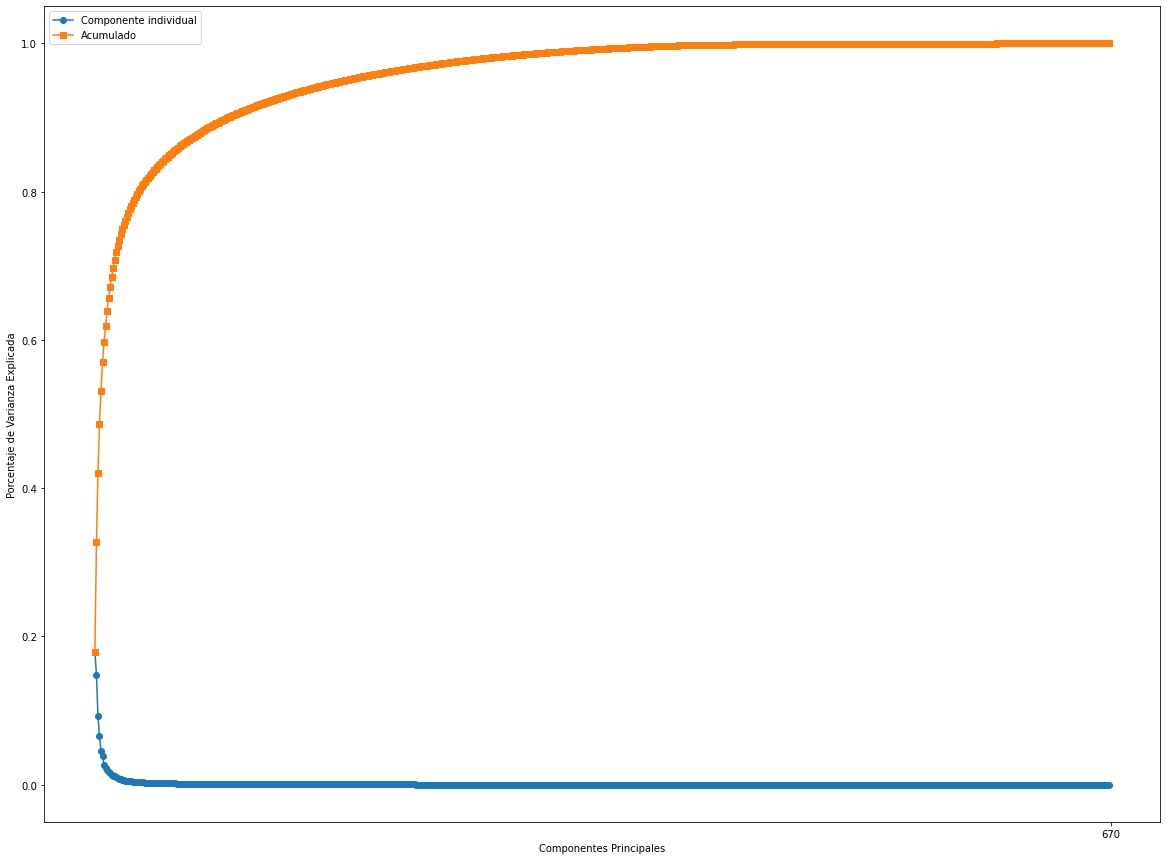

In [56]:
plt.figure(figsize=(20,15))

plt.plot(np.arange(df_pca.shape[0]), pca_pixels.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.arange(df_pca.shape[0]), np.cumsum(pca_pixels.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada')
plt.xlabel('Componentes Principales')

plt.xticks([df_pca.shape[0]])
plt.legend(loc=2);

## PCA para visualizar datos

Vamos a proyectar los datos del dataset de digitos en las primeras dos componenetes principales, y vamos a usar esta proyección para visualizar los datos


In [57]:
pca_digits_vis = PCA(n_components=670)
projected = pca_digits_vis.fit_transform(data_features)
print(data_features.shape)
print(data_features.shape)

(670, 10000)
(670, 10000)


Definimos una función para plotear los dígitos en 2 dimensiones generados por PCA

In [58]:
def plot_digits_pca(projection, numbers):
    
    colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
    plt.figure(figsize=(10,10))
    plt.xlim(projection[:,0].min(), projection[:,0].max())
    plt.ylim(projection[:,1].min(), projection[:,1].max())

    for i in range(len(projection)):
        plt.text(projection[i,0], projection[i,1], str(numbers[i]),
                color=colors[numbers[i]], fontdict={'weight':'bold', 'size':9})
    plt.xlabel('Primer Componente Principal')
    plt.ylabel('Segundo Componente Principal')

Ploteamos los dígitos proyectados con PCA

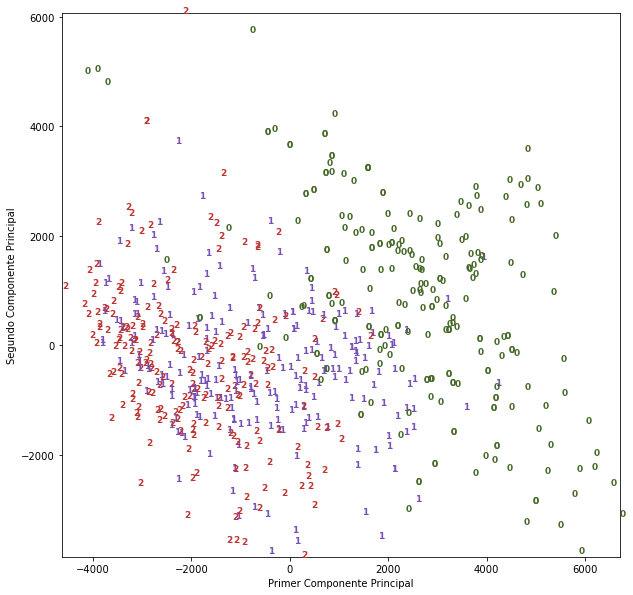

In [59]:
plot_digits_pca(projected, data_target)

Vemos que PCA logró encontrar alguna estructura en los datos pero no llegó a separar bien a la mayoría de los números. Por ejemplo, el segundo componente parece distinguir bien entre 0 y 1. 

Un punto importante a remarcar es que estamos ploteando usando las etiquetas de los registros. Es decir, tenemos más información que la que tendríamos en un problema típico de aprendizaje no supervisado. 

Veamos cuál sería el resultado del ploteo sin las etiquetas:

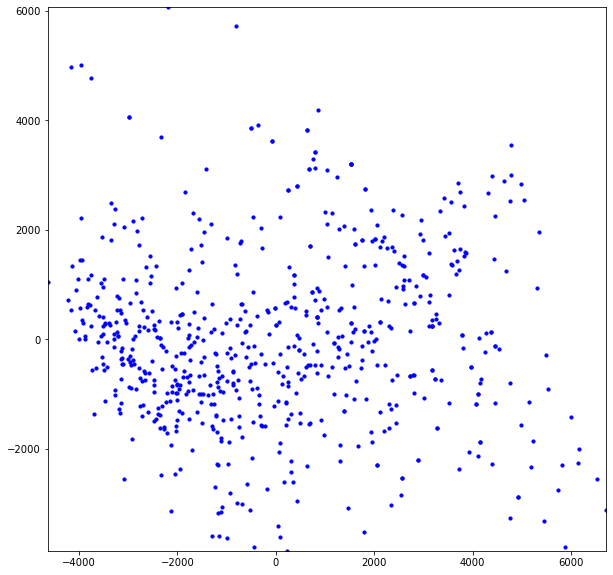

In [60]:
plt.figure(figsize=(10,10))
plt.xlim(projected[:,0].min(), projected[:,0].max())
plt.ylim(projected[:,1].min(), projected[:,1].max())

for i in range(len(projected)):
    plt.scatter(projected[i,0], projected[i,1], color='b', s=10)

Podemos intuir algún tipo de estructura o separación entre grupos, pero evidentemente los datos son demasiado complejos y no lineales para que PCA pueda capturar correctamente la estructura y separarlos en grupos distintos (acorde a su etiqueta).

---

In [61]:
import numpy as np
import skimage
import skimage.io
import skimage.transform

In [62]:
min(10000, 670)

670

In [63]:
data

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,target
0,57,65,68,64,65,69,70,63,56,52,...,116,61,24,8,2,0,0,0,0,1
1,20,30,38,85,110,116,145,116,122,115,...,107,80,151,129,77,12,0,0,0,1
2,0,0,0,139,143,196,178,172,169,168,...,27,2,7,13,21,21,0,0,0,1
3,0,0,0,42,32,34,44,46,53,182,...,102,175,178,163,252,255,0,0,0,1
4,0,0,0,0,99,109,115,119,127,174,...,23,2,5,8,9,9,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,16,9,6,5,4,3,9,12,12,16,...,101,89,72,66,57,39,5,3,16,0
666,7,8,8,8,7,7,7,6,6,5,...,28,2,2,5,8,10,11,12,30,0
667,46,32,27,253,225,237,238,96,41,42,...,56,28,30,33,36,37,38,44,52,0
668,1,0,0,0,0,1,1,1,1,1,...,169,132,63,16,2,0,0,0,1,0


In [64]:
target_covid_mask = data.target == 0
target_normal_mask = data.target == 1
target_pneumonia_mask = data.target == 2

In [65]:
data_features_covid = data.loc[target_covid_mask, data.columns.drop('target')]
data_features_normal = data.loc[target_normal_mask, data.columns.drop('target')]
data_features_pneumonia = data.loc[target_pneumonia_mask, data.columns.drop('target')]

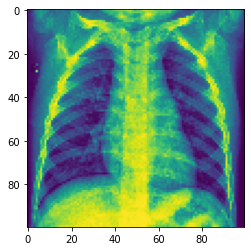

In [66]:
img_test = np.array(data_features.iloc[1, :])
img_test = img_test.reshape(100,100)
plt.imshow(img_test)
plt.show()

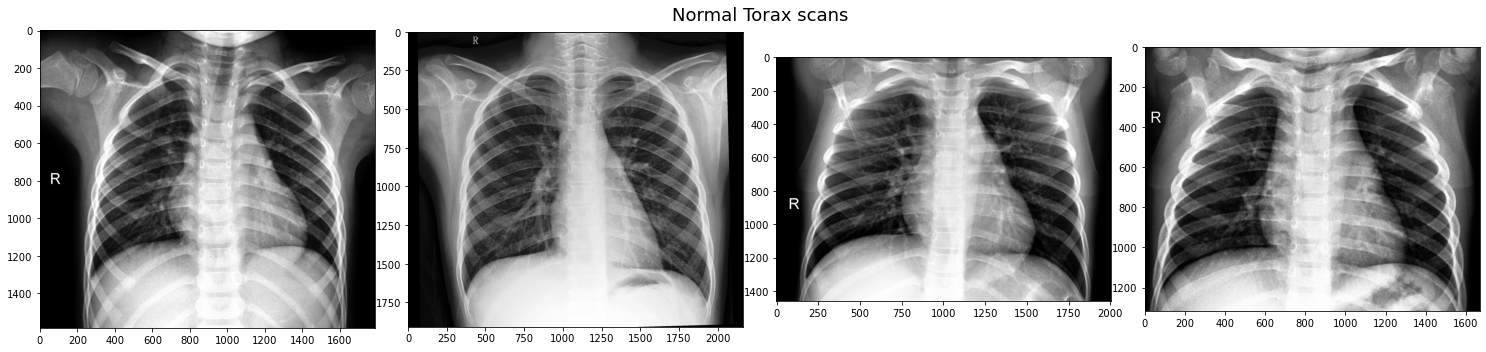

In [67]:
fig, axs = plt.subplots(1,4,figsize=(20,20))
fig.suptitle('Normal Torax scans', y=0.62, fontsize=18)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)
axs[0].imshow(imnor1)
axs[1].imshow(imnor2)
axs[2].imshow(imnor3)
axs[3].imshow(imnor4)
plt.show()

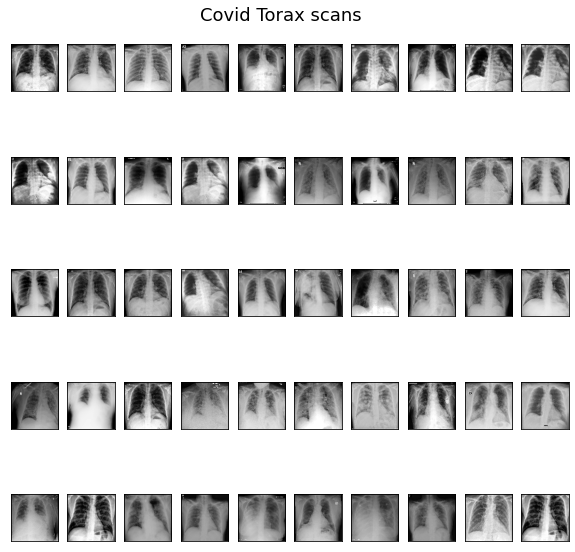

In [68]:
fig, ax = plt.subplots(5, 10, figsize=(10,10), subplot_kw=dict(xticks=[], yticks=[]))
fig.suptitle('Covid Torax scans', y=0.9, fontsize=18)
for i, axi in enumerate(ax.flat):
    img_test = np.array(data_features_covid.iloc[i, :])
    img_test = img_test.reshape(100,100)
    axi.imshow(img_test, cmap='gray')

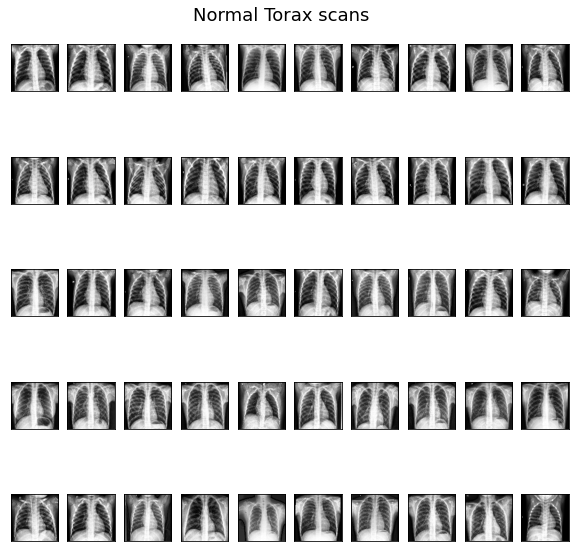

In [69]:
fig, ax = plt.subplots(5, 10, figsize=(10,10), subplot_kw=dict(xticks=[], yticks=[]))
fig.suptitle('Normal Torax scans', y=0.9, fontsize=18)
for i, axi in enumerate(ax.flat):
    img_test = np.array(data_features_normal.iloc[i, :])
    img_test = img_test.reshape(100,100)
    axi.imshow(img_test, cmap='gray')

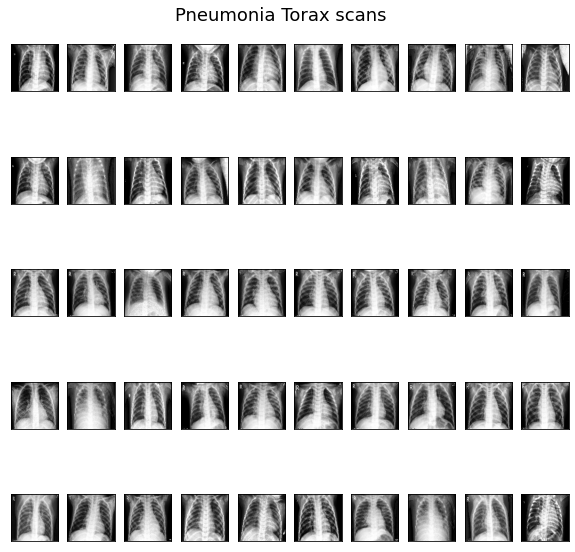

In [70]:
fig, ax = plt.subplots(5, 10, figsize=(10,10), subplot_kw=dict(xticks=[], yticks=[]))
fig.suptitle('Pneumonia Torax scans', y=0.9, fontsize=18)
for i, axi in enumerate(ax.flat):
    img_test = np.array(data_features_pneumonia.iloc[i, :])
    img_test = img_test.reshape(100,100)
    axi.imshow(img_test, cmap='gray')

(670,)
[0.17903995 0.32741626 0.420439   0.4862022  0.53151031 0.56984435
 0.59685105 0.6190616  0.63847474 0.65607607 0.67212778 0.68510728
 0.69694514 0.7081318  0.71860707 0.72720125 0.73523108 0.74263818
 0.74950483 0.75525972 0.76071108 0.76604309 0.77126288 0.77612605
 0.78064323 0.78498751 0.78914722 0.79309707 0.79689931 0.80056278
 0.80403554 0.80733303 0.81044814 0.81337914 0.81619405 0.81890546
 0.82157091 0.8240698  0.82650585 0.82885159 0.83115188 0.83336834
 0.83555132 0.83765545 0.83973968 0.8417182  0.84366482 0.84557972
 0.84746051 0.84928884 0.85111461 0.85289041 0.85460551 0.85629131
 0.8579459  0.85958509 0.86116609 0.8627375  0.8642459  0.86574549
 0.86722939 0.8686906  0.87010664 0.87151284 0.87288758 0.87423137
 0.87555677 0.87686171 0.87813297 0.87940347 0.88064369 0.88188125
 0.8830955  0.8842971  0.88546855 0.88663715 0.88776794 0.88887695
 0.88996267 0.89103783 0.89210602 0.89315404 0.89419862 0.89523054
 0.89623763 0.89723091 0.89822226 0.89920009 0.90016597

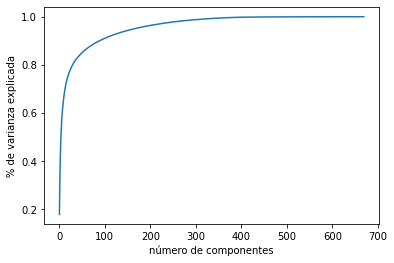

In [71]:
std_sclr = StandardScaler()
X_std_pca = std_sclr.fit_transform(data_features)

model_pca = PCA().fit(X_std_pca)

explained_variance = model_pca.explained_variance_ratio_
print(model_pca.explained_variance_ratio_.shape)

#print(explained_variance)

cumulative_explained_variance = np.cumsum(explained_variance)

print(cumulative_explained_variance)

plt.plot(cumulative_explained_variance)
plt.xlabel('número de componentes')
plt.ylabel('% de varianza explicada');

In [72]:
def plot_components(proj, ax=None, thumb_frac=0.05, cmap='gray'):
    
    fig, ax = plt.subplots(figsize=(15, 15))

    # get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
    ax = ax or plt.gca()
    
    coord_x = proj[:, 0]
    coord_y = proj[:, 1]
    ax.plot(coord_x, coord_y, '.k')    
    # símbolo . color k (black)

In [73]:
def plot_components_img(proj, images=None, ax=None, thumb_frac=0.05, numbers=None, cmap='gray'):
    
    colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
    
    fig, ax = plt.subplots(figsize=(15, 15))

    # get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
    ax = ax or plt.gca()
    
    coord_x = proj[:, 0]
    coord_y = proj[:, 1]
    #ax.plot(coord_x, coord_y, '.k')    
    # símbolo . color k (black)
    
    for i in range(len(proj)):
        ax.text(proj[i,0], proj[i,1], str(numbers[i]))
    '''
    if images is not None:
                
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        
        for i in range(proj.shape[0]):
            
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            
            # don't show points that are too close
            if np.min(dist) >= min_dist_2:                        
                
                #https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
                shown_images = np.vstack([shown_images, proj[i]])
            
                # grafica las thumbnails:
                imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], zoom=0.25, cmap=cmap), proj[i])
                ax.add_artist(imagebox)
    '''            

In [128]:
def plot_digits_tsne(projection, numbers, images):
    
    colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
    
    fig, ax = plt.subplots(figsize=(20,20))
    
    for i in zip(range(len(projection)), images):
        ax.text(projection[i,0], projection[i,1], str(numbers[i]))
        ax.imshow(images)
        
    fig.xlabel('Primer Componente Principal')
    fig.ylabel('Segundo Componente Principal')

In [74]:
data_features

,px_0,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_9990,px_9991,px_9992,px_9993,px_9994,px_9995,px_9996,px_9997,px_9998,px_9999
img_0,57,65,68,64,65,69,70,63,56,52,...,123,116,61,24,8,2,0,0,0,0
img_1,20,30,38,85,110,116,145,116,122,115,...,121,107,80,151,129,77,12,0,0,0
img_2,0,0,0,139,143,196,178,172,169,168,...,48,27,2,7,13,21,21,0,0,0
img_3,0,0,0,42,32,34,44,46,53,182,...,135,102,175,178,163,252,255,0,0,0
img_4,0,0,0,0,99,109,115,119,127,174,...,34,23,2,5,8,9,9,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
img_665,16,9,6,5,4,3,9,12,12,16,...,108,101,89,72,66,57,39,5,3,16
img_666,7,8,8,8,7,7,7,6,6,5,...,36,28,2,2,5,8,10,11,12,30
img_667,46,32,27,253,225,237,238,96,41,42,...,76,56,28,30,33,36,37,38,44,52
img_668,1,0,0,0,0,1,1,1,1,1,...,177,169,132,63,16,2,0,0,0,1


In [75]:
pca_2cp = PCA(n_components=2)
proj_pca = pca_2cp.fit_transform(X_std_pca)
proj_pca

array([[-39.36089768, -12.8581381 ],
       [-11.01739479, -22.03646553],
       [-65.5294071 , -17.87258285],
       ...,
       [ 15.8319151 , -19.39543266],
       [ 51.50160016, -25.93192841],
       [ 39.79218808, -11.76442292]])

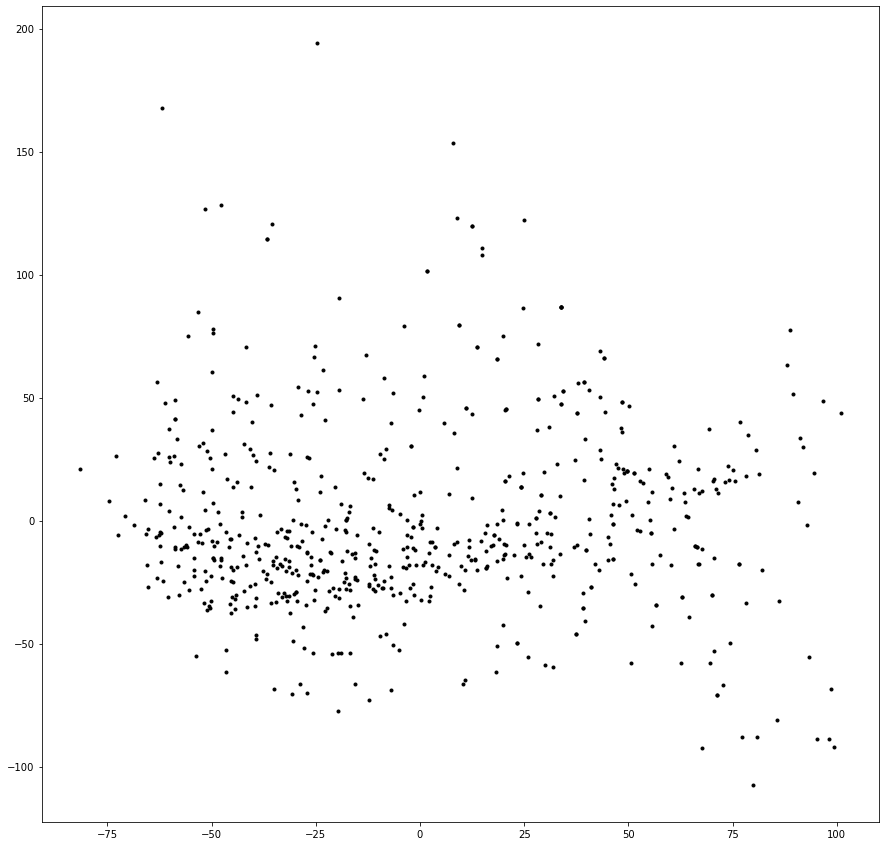

In [76]:
# list[<start>:<stop>:<step>]
plot_components(proj_pca)
#plot_components(proj_iso, images=faces.images[:, :, :])
#plot_components(proj_iso, images=faces.images[:, ::3, ::3])

## Ejercicio 5 - Isomap

Proyectemos ahora los datos en 2 dimensiones usando Isomap y usemos `plot_components` para visualizar los resultados

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap

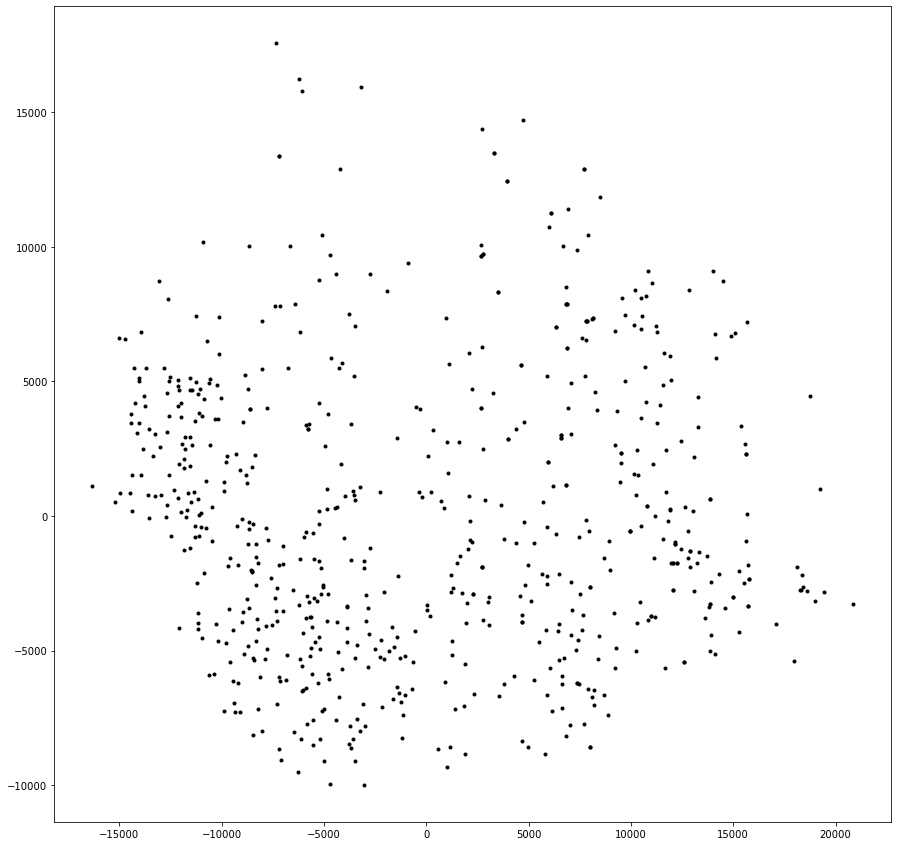

In [77]:
isomap_2cp = Isomap(n_components=2)
proj_iso = isomap_2cp.fit_transform(data_features)

plot_components(proj_iso)


## Ejercicio 6 - TSNE

Proyectemos ahora los datos en 2 dimensiones usando T-SNE y usemos `plot_components` para visualizar los resultados

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE

In [78]:
#tsne = TSNE(n_components=2, perplexity=10.0)
#tsne_result = tsne.fit_transform(pca_result)
#tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
#visualize_scatter(tsne_result_scaled, label_ids)

In [79]:
data_features

,px_0,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_9990,px_9991,px_9992,px_9993,px_9994,px_9995,px_9996,px_9997,px_9998,px_9999
img_0,57,65,68,64,65,69,70,63,56,52,...,123,116,61,24,8,2,0,0,0,0
img_1,20,30,38,85,110,116,145,116,122,115,...,121,107,80,151,129,77,12,0,0,0
img_2,0,0,0,139,143,196,178,172,169,168,...,48,27,2,7,13,21,21,0,0,0
img_3,0,0,0,42,32,34,44,46,53,182,...,135,102,175,178,163,252,255,0,0,0
img_4,0,0,0,0,99,109,115,119,127,174,...,34,23,2,5,8,9,9,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
img_665,16,9,6,5,4,3,9,12,12,16,...,108,101,89,72,66,57,39,5,3,16
img_666,7,8,8,8,7,7,7,6,6,5,...,36,28,2,2,5,8,10,11,12,30
img_667,46,32,27,253,225,237,238,96,41,42,...,76,56,28,30,33,36,37,38,44,52
img_668,1,0,0,0,0,1,1,1,1,1,...,177,169,132,63,16,2,0,0,0,1


In [80]:
data_features.shape[0]

670

In [81]:
np.array(data_features)
imgmatrix = [np.array(data_features)[x].reshape(100,100) for x in range(data_features.shape[0])]

In [82]:
imgmatrix = np.array(imgmatrix)
imgmatrix.shape

(670, 100, 100)

In [83]:
imgmatrix[1]

array([[ 20,  30,  38, ..., 120,  98,  46],
       [ 25,  22,  49, ..., 134,  98,  49],
       [ 26,  31,  59, ..., 110,  92,  48],
       ...,
       [  0,  21,  75, ...,   1,   0,   0],
       [  2,  24,  69, ...,   1,   0,   0],
       [  1,  36,  73, ...,   0,   0,   0]], dtype=uint8)

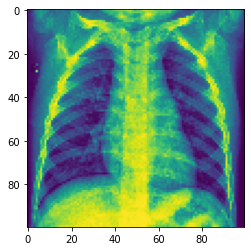

In [84]:
plt.imshow(imgmatrix[1])
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

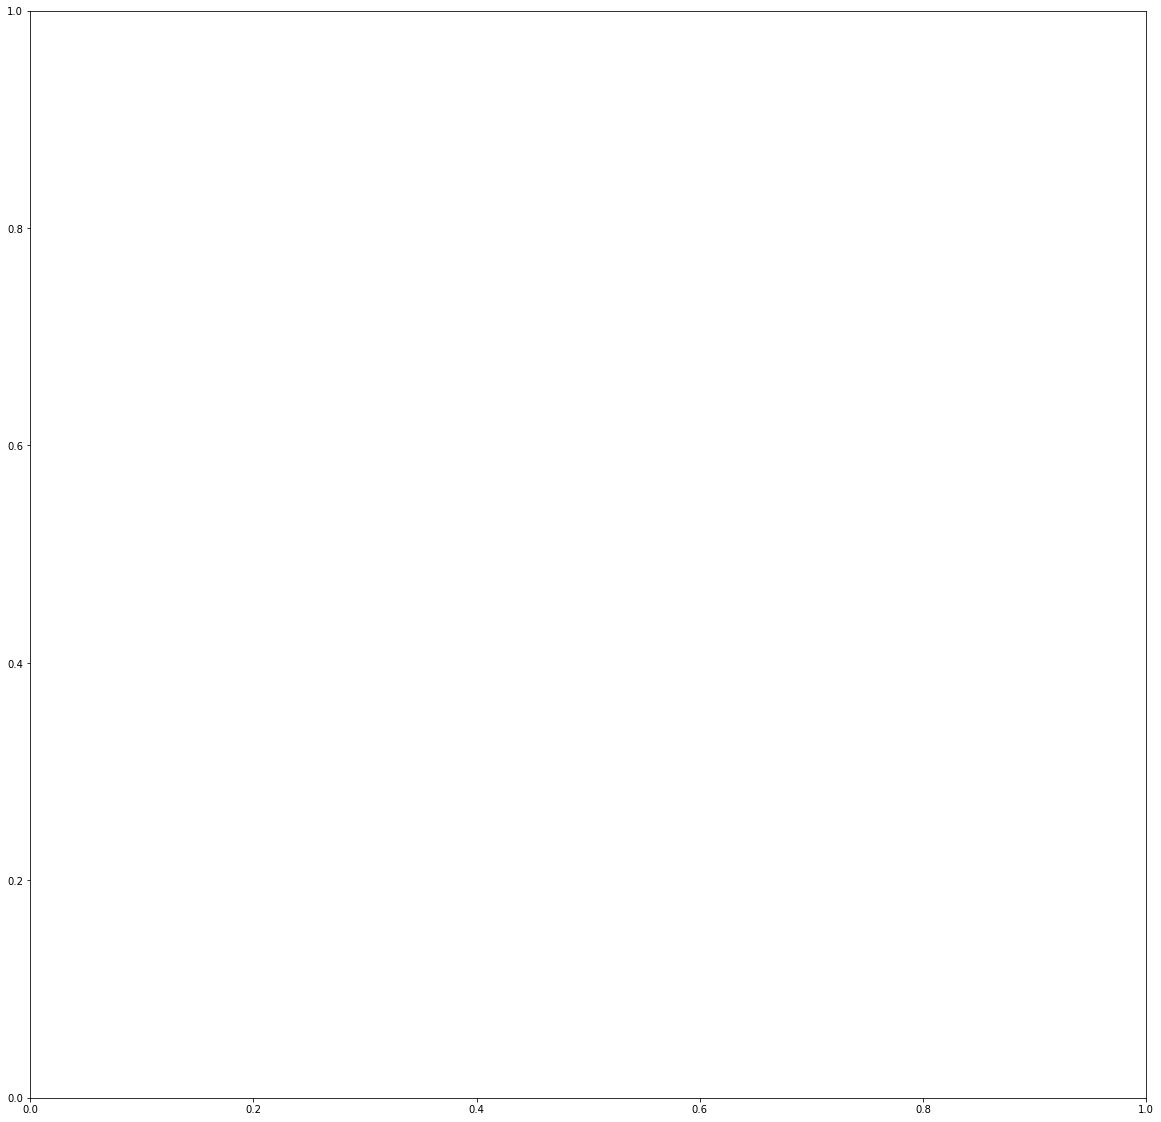

In [129]:
tsne = TSNE(n_components=2, random_state=42)

proj_tsne = tsne.fit_transform(data_features)

plot_digits_tsne(proj_tsne, images=imgmatrix, numbers=data_target)
    

In [86]:
tsne = TSNE(n_components=2, random_state=42)

proj_tsne = tsne.fit_transform(data_features)

plot_components_img(proj_tsne, images=imgmatrix, numbers=data_target)

ValueError: Image size of 72529x76094 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1080x1080 with 1 Axes>

In [85]:
proj_tsne[1, :]

NameError: name 'proj_tsne' is not defined

El resultado es interesante: las primeras dos dimensiones del T-SNE parecen describir dos características globales de las imágenes.
    
  * el brillo parece decrecer de abajo hacia arriba
  * la orientación de la cara parece variar de derecha a izquierda

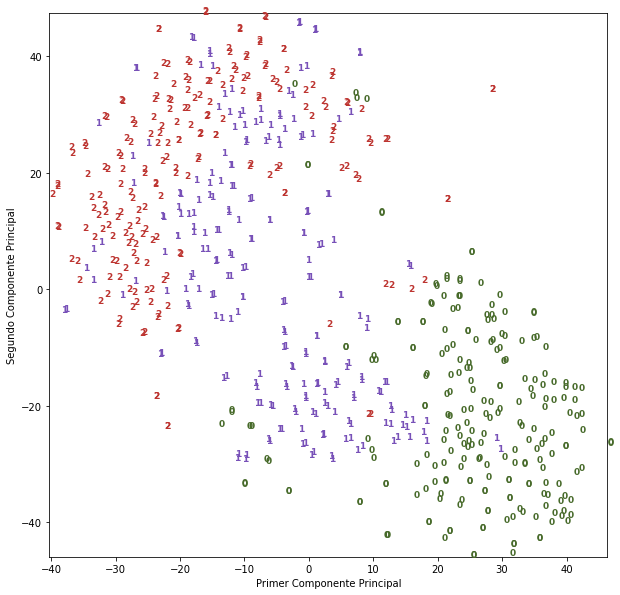

In [96]:
plot_digits_pca(proj_tsne, data_target)

In [105]:
projected

array([[-2.02624381e+03, -9.92427897e+02, -2.24401565e+03, ...,
         1.46481207e-36,  4.41859611e-16, -7.03990355e-16],
       [-3.74314994e+02, -8.86034520e+02, -1.62841579e+03, ...,
        -3.93272288e-28,  4.41859611e-16, -7.03990355e-16],
       [-3.42280705e+03, -5.13861437e+02, -4.39646640e+02, ...,
         1.32804685e-27,  4.41859611e-16, -7.03990355e-16],
       ...,
       [ 1.38265776e+03, -1.31693274e+03,  7.16978835e+02, ...,
        -3.55040863e-14,  6.41915500e-13,  1.18904646e-13],
       [ 2.34061217e+03,  2.03179066e+02,  2.96052663e+03, ...,
        -1.10734935e-28,  4.41859611e-16, -7.03990355e-16],
       [ 2.72684731e+03, -6.81786049e+02,  2.42794730e+03, ...,
         1.28224292e-15, -5.78091635e-13, -1.13234603e-13]])

In [106]:
proj_tsne

array([[-18.519629 ,  12.70568  ],
       [-15.356597 ,  -1.2281847],
       [ -5.1667376,  29.71852  ],
       ...,
       [  7.4230647, -36.89882  ],
       [ 11.829902 , -42.5548   ],
       [ 18.107405 , -40.258533 ]], dtype=float32)

In [107]:
projected.shape, proj_tsne.shape

((670, 670), (670, 2))

In [108]:
len(projected), len(proj_tsne)

(670, 670)

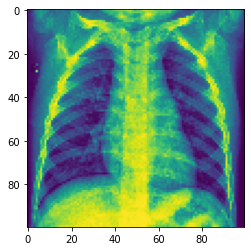

In [124]:
plt.imshow(imgmatrix[1])

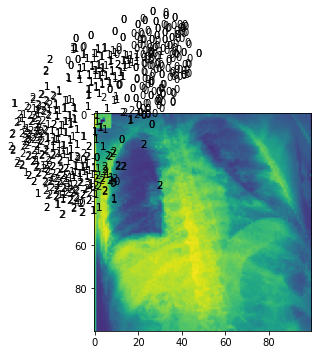

In [125]:
for i, images in zip(range(len(proj_tsne)), imgmatrix):
    plt.text(proj_tsne[i,0], proj_tsne[i,1], str(data_target[i]))
    plt.imshow(images)
        